In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit
import os

# Varying Noise Amplitude

This notebook repeats the computation of the average Lyapunov exponent, itearating over different noise amplitudes. White noise is added to bed elevations at each step with amplitude varying from $2*10^-4$ to $8*10^-3$. Each amplitude 

The figures of the average Lyapunov exponent notebook are produced for each amplitude as animation frames.

## Prerequsites
Needs the output folders amp_i from `varying_amplitude.m` placed in the `varying_amplitude_runs` directory.

In [2]:
def generate_frame(eta_base, eta_perturbed):
    eta_comps = []
    times = []

    for file in os.listdir(eta_perturbed):
        eta_comps.append(scipy.io.loadmat(f'{eta_perturbed}/{file}')['eta_save'])
        times = scipy.io.loadmat(f'{eta_perturbed}/{file}')['t_save'][0]

    ds = []
    for eta_comp in eta_comps:
        d = []
        for t in range(eta_comp.shape[1]):
            d_j = 0
            for j in range(6):
                d_j += np.abs(eta_comp[j+1][t] - eta_base[j+1][t])
            d.append(d_j)

        d = np.array(d)
        ds.append(d)


    d_average = []
    for t in range(eta_comp.shape[1]):
        d_average.append(np.average(np.array(ds)[:,t]))
    d_average = np.array(d_average)

    # General exponential function
    def f(t,k, d_0, t_0):
        return d_0*np.exp(k*(t-t_0))

    lower_bounds = np.linspace(0, 1000, 10)
    upper_bounds = np.linspace(3000,4000,10)

    best_lower_bound = 0
    best_upper_bound= 4000
    best_bounds_r_squared = 0

    for lower_bound in lower_bounds:
        for upper_bound in upper_bounds:

            lower_bound = int(lower_bound)
            upper_bound = int(upper_bound)

            if upper_bound > lower_bound:
                d_average_truncated = np.copy(d_average)[lower_bound:upper_bound]
                times_truncated = np.copy(times)[lower_bound:upper_bound]

                popt, pcov = curve_fit(lambda t, b: d_average_truncated[0] * np.exp(b * (t-times_truncated[0])),  times_truncated, d_average_truncated)

                residuals = np.sum((d_average_truncated - f(times_truncated, popt[0], d_average_truncated[0], times_truncated[0]))**2)

                sum_squares = np.sum((d_average_truncated - np.mean(d_average_truncated))**2)

                r_squared = 1 - (residuals / sum_squares)

                if 1-r_squared < 1-best_bounds_r_squared:
                    best_bounds_r_squared = r_squared
                    best_lower_bound = lower_bound
                    best_upper_bound = upper_bound



    d_average = d_average[best_lower_bound : best_upper_bound]
    times = times[best_lower_bound : best_upper_bound]

    popt, pcov = curve_fit(lambda t, b: d_average[0] * np.exp(b * (t-times[0])), times, d_average)

    residuals = np.sum((d_average - f(times,popt[0], d_average[0], times[0]))**2)

    sum_squares = np.sum((d_average-np.mean(d_average))**2)

    r_squared = 1 - (residuals / sum_squares)

    plt.figure()
    plt.plot(times, d_average)
    plt.plot(times, f(times, popt[0], d_average[0], times[0]))
    plt.xlabel('t')
    plt.ylabel('$|d|$')
    plt.legend(['$|d|$', '$y = d_0 e^{\lambda t}$, $\lambda = $' + str(np.round(popt[0], 2)) + ', $r^2$ = ' + str(np.round(r_squared,2))])

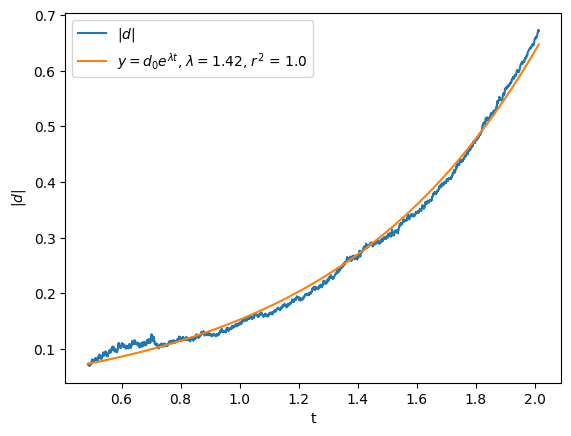

In [3]:
for i in range(1):
    generate_frame(scipy.io.loadmat(f'varying_amplitude_runs/amp_{i+1}/eta_base.mat')['eta_save'], f'varying_amplitude_runs/amp_{i+1}/eta_perturbed')

